In [13]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *
from analysis import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
loaded = False

# Load BioBank Components

In [4]:
DEV_MODE = False
SIGNIFIER = ""

if not loaded:
    (biobank_data_no_HLA_alleles, biobank_index,
     med_code_mapping) = data_tools.load_all_biobank_components(DEV_MODE, signifier=SIGNIFIER)
    loaded = True
    HLA_alleles = data_tools.load_HLA_data()
    biobank_data = biobank_data_no_HLA_alleles.merge(HLA_alleles, how="left", on="eid")

Importing BioBank Index and Data:
Missing 0 biobank index names
Reduced feature set has 369 features.
UK BioBank Data Loaded.
Size: 502536 rows x 369 columns
Elapsed time: 60.4239 seconds


Mapping Medical Codes:   0%|          | 0/354 [00:00<?, ? feature/s]

# Conditions / Condition Search

In [11]:
autoimmune_conditions = ["type 1 diabetes", "gestational diabetes", "rheumatoid arthritis",
                         "psoriasis", "asthma", "multiple sclerosis", "systemic lupus erythematosis/sle",
                         "inflammatory bowel disease", "grave's disease", "hypothyroidism/myxoedema",
                         "hyperthyroidism/thyrotoxicosis", "myasthenia gravis", "pernicious anaemia",
                         "sjogren's syndrome/sicca syndrome", "eczema/dermatitis",
                         'acute infective polyneuritis/guillain-barre syndrome', "malabsorption/coeliac disease",
                        ]

psychiatric_conditions = ["schizophrenia", "depression", "mania/bipolar disorder/manic depression",
                          "obsessive compulsive disorder (ocd)", "anxiety/panic attacks",
                          "alcohol dependency"]

HLA_dosing_conditions = {"psychiatric": psychiatric_conditions, "autoimmune": autoimmune_conditions}

other_conditions = ["vasculitis", "hypertension"]
neurological_conditions = ["epilepsy"]

data_tools.biobank_search(med_code_mapping, biobank_data, ('alz')).query("count > 0")

,coding,meaning,code_format,name,count
136,1263,dementia/alzheimers/cognitive impairment,6,illness_code,39


In [39]:
def get_base_feature(feature: str) -> str:
    """ """
    return "_".join(feature.split("_")[:-1]) if "." in feature else feature

In [63]:
def get_illness_value(data: pd.DataFrame, illness: str, base_feature: str) -> np.ndarray:
    """ Finds all the individuals with a specific illness"""
    assert base_feature in data, f"Invalid base_feature: {base_feature}"
    
    features = [feature for feature in data.columns if get_base_feature(feature) == base_feature]
    
    illness_value = np.zeros(len(data))
    for feature in features:
        illness_value = (data[feature] == illness) | illness_value

    return illness_value

In [72]:
illness_values = get_illness_value(biobank_data, "hodgkins lymphoma / hodgkins disease", "cancer_code")
print(variable_OR_test(biobank_data, "zygosity"))

In [73]:
calculate_OR(illness_values, biobank_data["zygosity"] != 0)

(1.3669320188466525,
 0.002031362024411291,
 1.1611920153686213,
 1.6091250365298346)

In [62]:
for illness in psychiatric_conditions:
    print(illness.upper())
    biobank_data["illness_value"] = get_illness_value(biobank_data, illness, "illness_code")
    print("\t" + variable_OR_test(biobank_data, "zygosity").replace('\n', '\n\t'))

SCHIZOPHRENIA
	zygosity = 1.0:  OR = 0.906   p-value = 0.45526   95% CI: 0.75 - 1.10   N = 84
	zygosity = 2.0:  OR = 0.741   p-value = 0.22959   95% CI: 0.51 - 1.08   N = 20
	zygosity = 3.0:  OR = 1.335   p-value = 0.19990   95% CI: 0.92 - 1.93   N = 21
	
DEPRESSION
	zygosity = 1.0:  OR = 0.992   p-value = 0.65396   95% CI: 0.96 - 1.02   N = 4,257
	zygosity = 2.0:  OR = 0.986   p-value = 0.66363   95% CI: 0.94 - 1.04   N = 1,232
	zygosity = 3.0:  OR = 1.072   p-value = 0.06846   95% CI: 1.01 - 1.14   N = 777
	
MANIA/BIPOLAR DISORDER/MANIC DEPRESSION
	zygosity = 1.0:  OR = 0.971   p-value = 0.73570   95% CI: 0.86 - 1.10   N = 209
	zygosity = 2.0:  OR = 0.990   p-value = 1.00000   95% CI: 0.80 - 1.23   N = 62
	zygosity = 3.0:  OR = 0.903   p-value = 0.67249   95% CI: 0.67 - 1.21   N = 33
	
OBSESSIVE COMPULSIVE DISORDER (OCD)
	zygosity = 1.0:  OR = 0.796   p-value = 0.57998   95% CI: 0.49 - 1.30   N = 13
	zygosity = 2.0:  OR = 1.263   p-value = 0.48470   95% CI: 0.63 - 2.53   N = 6
	zygos

# Grantham Distance Plots 

Making OR Plots:   0%|          | 0/6 [00:00<?, ? plot/s]

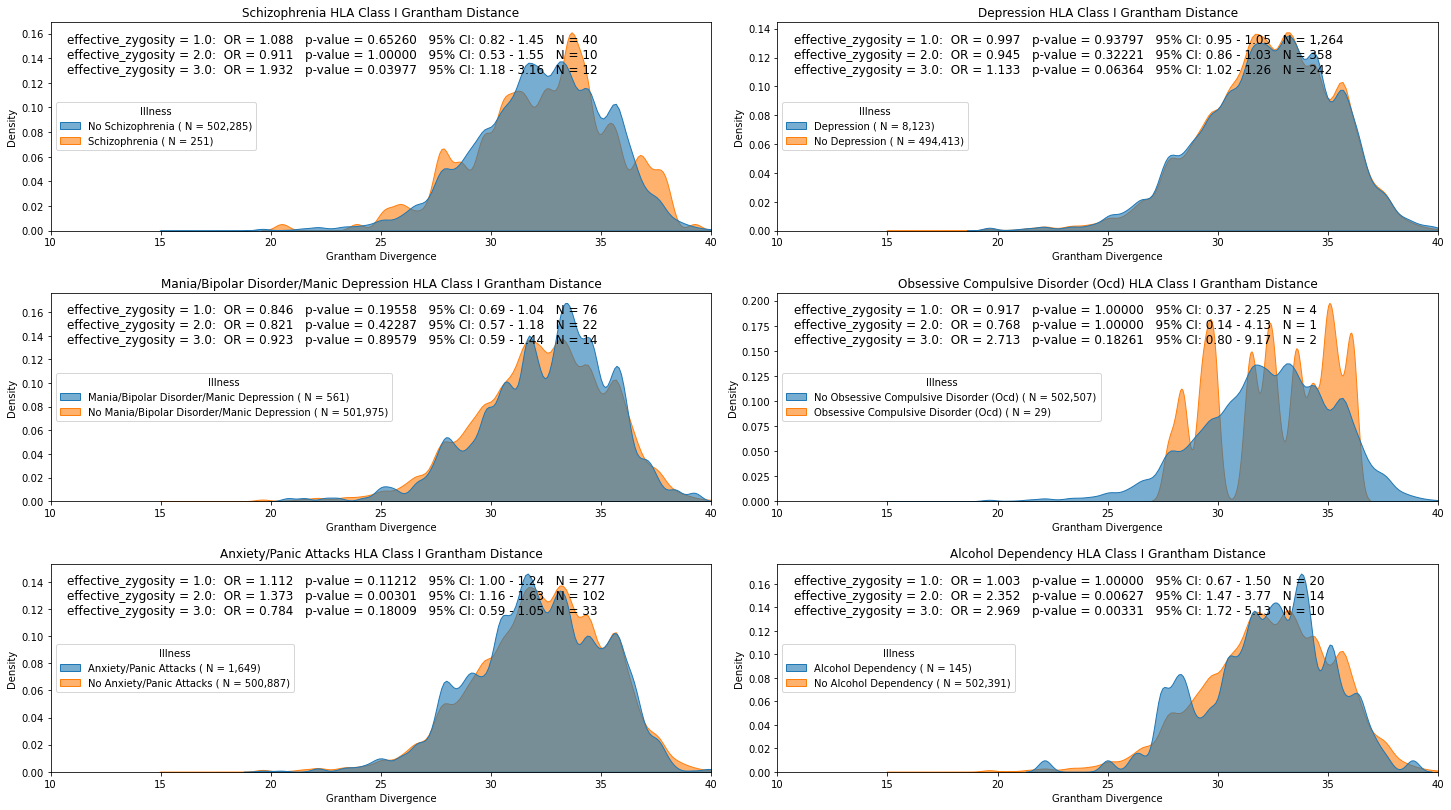

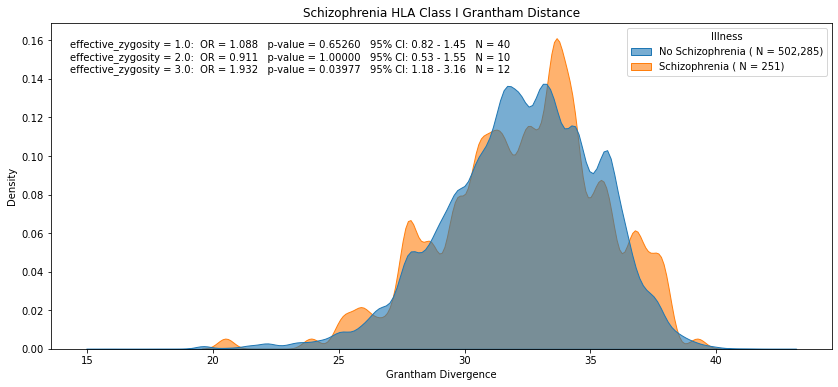

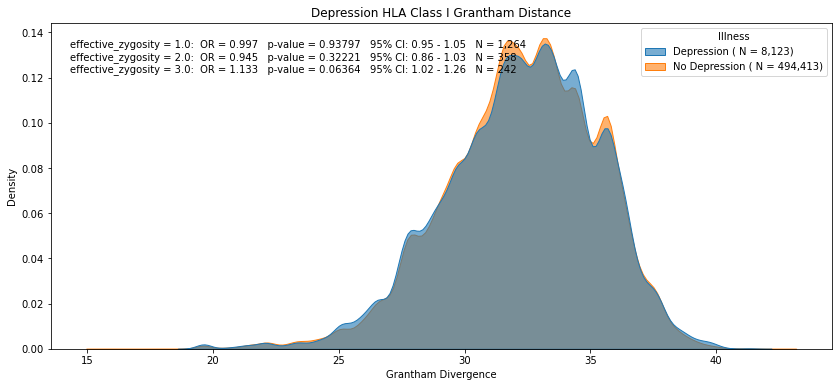

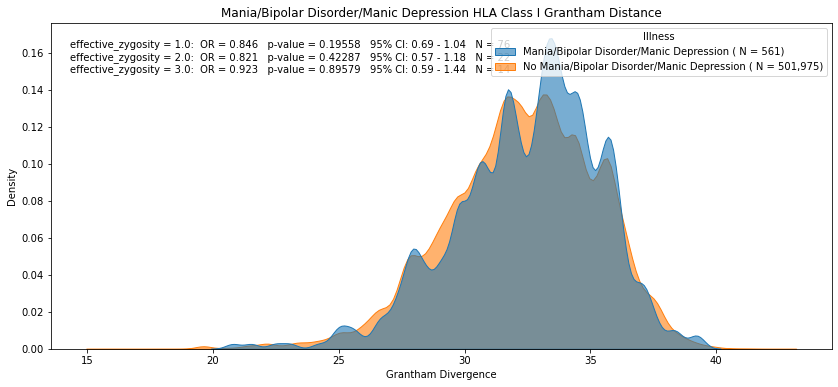

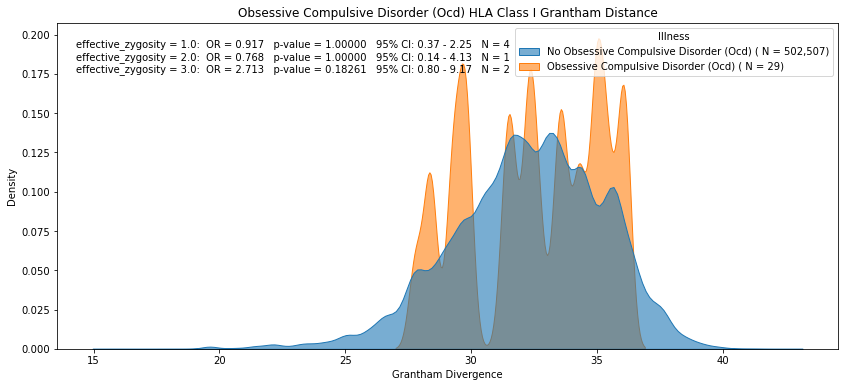

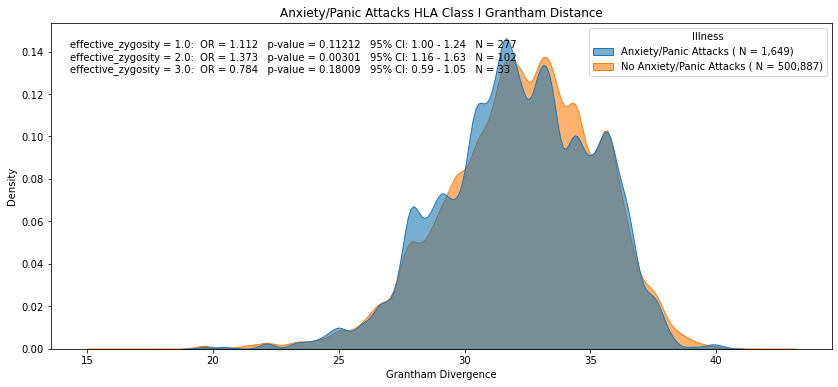

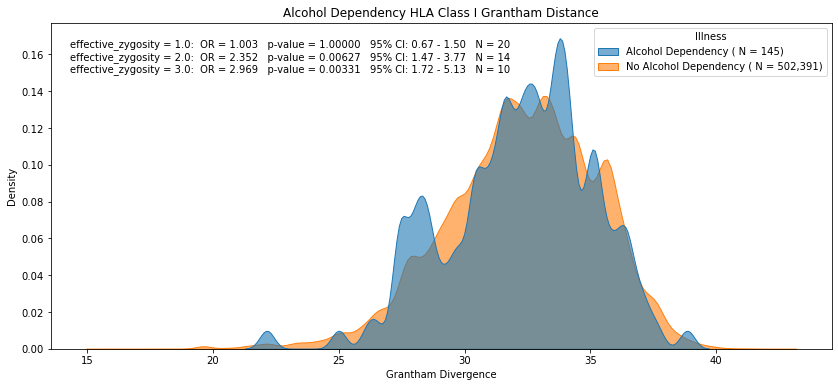

In [29]:
condition = "psychiatric"

conditions = HLA_dosing_conditions[condition]

big_fig, big_axes = create_subplot(len(conditions), width=20, height_per=3, wspace=.1)

for illness, big_ax in tqdm(zip(conditions, big_axes), unit=" plot", desc="Making OR Plots",
                            total=len(big_axes)):

    fig, ax = plt.subplots(figsize=(14, 6))
    x = "grantham_divergence"
    biobank_data["illness_value"] = 1 * (biobank_data["illness_code"] == illness)
    biobank_data["illness"] = np.array(["no " + illness, illness])[biobank_data["illness_value"].values]
    sns_wrapper(sns.kdeplot, data=biobank_data, x=x, hue="illness", ax=ax, bw_method=.1, common_norm=False, shade=True)
    sns_wrapper(sns.kdeplot, data=biobank_data, x=x, hue="illness", ax=big_ax, bw_method=.1, common_norm=False, shade=True)
    
    text = variable_OR_test(biobank_data, "effective_zygosity")

    add_plt_labels(ax, x=x)
    ax.set_title(f"{illness.title()} HLA Class I Grantham Distance")
    ax.text(0.025, 0.95, text, transform=ax.transAxes, ha="left", va="top")
    
    add_plt_labels(big_ax, x=x)
    big_ax.set_title(f"{illness.title()} HLA Class I Grantham Distance")
    big_ax.text(0.025, 0.95, text, transform=big_ax.transAxes, ha="left", va="top", fontsize=12)
    big_ax.legend(title="Illness", loc="center left")
    big_ax.set_xlim(10, 40)
    
    illness_label = illness.replace(' ', '_').replace('/', '_').replace("'", "")
    fig.savefig(f"cancer_ICD10_plots/grantham_distance_plots/{condition}/HLA_grantham_distance_{illness_label}.png")

big_fig.savefig(f"cancer_ICD10_plots/grantham_distance_plots/{condition}/multiple_HLA_grantham_distance.png")